
# Flower Species Classifier Project

Welcome! This project is designed to help you solidify key concepts in deep learning, such as:
- Building and training a Keras model.
- Understanding activation functions (logits, softmax, sigmoid, etc.).
- Using optimizers (especially ADAM) and understanding gradient descent.
- Applying regularization techniques (L1, L2, dropout, and batch normalization).
- Fine-tuning hyperparameters and employing early stopping.
- Evaluating model performance with appropriate metrics.

Let's get started!


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import cifar10

# Set random seed for reproducibility
tf.random.set_seed(42)


# `Sparse representation` versus `One hot encoding`

---

## What do they do
- Represent cateogrical data numerically 
- Where they differ --> How they handle large numbers of categories 

## Sparse  representation 
- More memory efficient 
  - By storing only `non-zero` values 
  - Makes it great for situations where most of the values are 0

## One hot encoding 
- Creates seperate binary column for `each category`
- Doing so can lead to potentially large, sparse matricies when dealing with alot of categories

<br>

---

<br>

## Reasoning why one hot encoding was picked 
### Simplicity and interpretability
  - One hot encoding super straight forward to implement/interpret 
  - Each class represented by a vector 
    - Elements represented as `1`
    - The rest are represented as `0`
    - Example for 3 classes 
      - Class 0: [1, 0, 0]
      - Class 1: [0, 1, 0]
      - Class 2: [0, 0, 1]

### Compatibility with loss functions
- Most classification loss functions like `cross entropy` 
  - `Expects` target labels to be `one-hot encoded` 
  - This format lets the loss function to compute probabilities for `each class` and `compares them with the actual class label`
- If labels were `NOT` one-hot encoded
  - Model would need extra logic to figure out which class corresponds to the ground truth

## Works well with Softmax
- Softmax function `used in the final layer` in of a multi-class classifier outputs the probabilities for each class 
- One hot encoded labels natrually align with these probabilities making the training process smooth

## Avoids Implicit Ordinal Assumptions 
- Not like integer encoding that would use 0,1,2,3
- One hot encoding ensure the model doesn't interpret the labels as ordinal (having meaningful order)
  - This prevents the model from assuming relationships like "Class 2 > Class 1 > Class 0."


# When is One-Hot Encoding Chosen for Simplicity?
## Small Number of Classes:
- One-hot encoding is especially simple and computationally efficient when the number of classes is small. 
- For example, in the flower classification task, 
  - There might be only 5-10 classes, making one-hot encoding a natural choice.

## Ease of Implementation:
- For beginners, one-hot encoding is easier to understand and implement than alternative methods like label encoding or embeddings.

<br>


---

## Conv2D() Parameter explanation
### Filters
- Number of `filters`/`kernels` in the convolutional layer 
- Each filter is responsible for detecting `specific patterns` or `features` in the input
- How it affects the model
  - Increasing the number of filters lets the `model learn more features` at the `cost of increased computational cost and memory usage`
### kernel_size
- Specifies the height/width of a filter/kernel
- It defines the `receptive field` 
  - How much of the input the filter 'sees' at a time
- Common choices 
  - 3,3 | 5,5 | 7,7
#### strides
- Controls the step size of the sliding window of the filter across the input 
  - Larger strides --> reduce spatial dimensions of the output feature map 
  - Aka : downsampling 
- Example : `strides=(2,2)` : moves filter 2 pixels at a time 
  - Effectively halving the spatial dimension 
#### padding
  - Determines how the borders of the input are handled
  - Options
    - `valid` : no padding --> Output size is reduced
    - `same`  : Pads the input so the `output size` is the same as the `input size` for strides of 1

There's alot more that I was to lazy to cover so I'll stop here

In [ ]:

# # Load the CIFAR-10 dataset (can be replaced with a flower dataset later)
# # What is CIFAR-10 : colection of images used to train ML and CV algorithms
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Normalize images to [0, 1] range
# x_train = x_train.astype("float32") / 255.0
# x_test = x_test.astype("float32") / 255.0

# # One-hot encode labels
# num_classes = 10
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

# # Class names for CIFAR-10 dataset
# CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# #print(len(CLASS_NAMES))

# # Visualize some sample images
# plt.figure(figsize=(10, 5))
# for i in range(len(CLASS_NAMES)):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(x_train[i])
#     plt.title(CLASS_NAMES[np.argmax(y_train[i])])
#     plt.axis("off")
# plt.show()


# Load the dataset (e.g., CIFAR-10 or any flower dataset)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10

# Normalize the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Prepare training and testing datasets
train_dataset = (
    # Creates a Dataset whose elements are slices of the given tensors.
    # Convets a pair of tensors like x_train and y_train into tf.data.Dataset 
    # Each element is a tuple (x,y) that corresponds to one training example
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024)
    # Groups the elements into batches so the model can process batches of "X" examples at a time
    .batch(32)
    # Loads data into memory while model is training on the previous batch to reduce input latency and to improve GPU utilization
    # AUTOTUNE : dynamically decides the number of batches to prefetch based on system resouces thus making it more efficient w/o manual tuning
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Python slicing : [1:] 
# Syntax for slicing : list_name[start : end : step
# We're extractin the second element to the end --> (32,32,3)
# We purposefully remove the first dimension since we don't know how many samples will be processed at once, thus we're able to handle any batch size
input_shape = x_train.shape[1:]  # Get the input shape for the model

print("Input shape : ", input_shape)

Input shape :  (32, 32, 3)


# Notes

## MaxPooling2D(poolSize_)
### Description
- Downsamples input along its spatial dimensions (height and width) by taking the maximum value over an input window of size defined by `pool_size` for each
channel of the input.
- The window is shifted by `strides` along each dimension.

### Syntax

```python
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None, **kwargs)
```

### Output Shape
- When using `valid` padding:
    - Has a spatial shape (number of rows x columns) of `output_shape = math.floor((input_shape - pool_size) / strides) + 1`
    - Only when `input_shape >= pool_size`
- When using the `same` padding option:
    - `output_shape = math.floor((input_shape - 1) / strides) + 1`

### Use Cases
- Intermediate layers
    - Typically used after convolutional layers to downsample spatial dimensions.
    - Or to reduce the size of feature maps before feeding them into a fully connected layer.

## BatchNormalization()
### Description
- Normalizes the inputs to a layer across the mini batch to have:
    - A mean of `0`
    - A standard deviation of `1`

### Speeds Up Training
- When normalizing the inputs, BN reduces the amount by which the internal activations are scaled.
- This leads to faster convergence and improved training stability.

### Code Example

```python
from tensorflow.keras.layers import BatchNormalization

batch_norm = BatchNormalization()
```

## Applying L1/L2 Regularization to Conv2D or Dense Layers
### Key Differences between Conv2D and Dense Layers

#### Conv2D Layer
- Operates on spatial data (images)
- Weights correspond to filters/kernels used for feature extraction
- Applying regularization here helps to reduce overfitting by encouraging simpler filters

#### Dense Layer
- Operates on fully connected neurons (flattened data)
- Weights used to learn high-level relationships between features
- Regularization helps reduce overfitting by controlling the complexity of the feature relationships

## Impact of Regularization
==========================

### Applying Regularization to Conv2D Layers
-----------------------------------------------

#### Advantages:
- Reduces overfitting of convolutional filters, making them more generalizable.
- Encourages filters to focus on simpler and more significant features in the data.
- Useful when dealing with large images or datasets prone to overfitting.

#### Use Case
-----------------

Apply L2 regularization (weight decay) to prevent filters from growing large and focusing on noise. L1 regularization can encourage sparsity, making some
filters "inactive," which may improve interpretability.

#### Code Example

```python
from tensorflow.keras.regularizers import l2

conv2d = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))
```

### Applying Regularization to Dense Layers
---------------------------------------------

Advantages:
- Controls overfitting in fully connected layers, which often have the most parameters.
- Encourages simpler relationships between features.

#### Use Case
-----------------

L2 regularization is commonly used in dense layers to reduce weight magnitude. L1 regularization is useful for sparse models.

### Applying Regularization to Output Layer
---------------------------------------------

- Is optional
- If applied and if the output layer is prone to overfitting due to small datasets or highly imbalanced classes, applying regularization --> helps stabilize
predictions
- Use weaker regularization here compared to hidden layers.
- Example:

```python
Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001))
```

## Importance of Input Shape
### Why is this important in NN?

#### Generalization across batches
- The model works with any batch size during training/inference
- By excluding the batch size the input shape can adapt dynamically

#### Defining layers
- Layers like Input() or Conv2D() need the input shape to be known to process the data
- Providing the input shape ensures the model is built correctly

In [23]:


# Define a CNN model
def build_model(input_shape, num_classes):
    filters = 32
    kernelSize = (3, 3)  # Fixed typo from "kernalSize"
    poolSize_ = (2, 2)  # Tuple --> Immutable collection of elements
    denseLayerNeurons = 128
    l2Regularization = 0.01

    model = Sequential([
        # Conv2D(Filters, KernelSize, Strides, Padding, ActivationFunction)
        Conv2D(filters, kernelSize, activation='relu', input_shape=input_shape),

        # keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None, **kwargs
        MaxPooling2D(poolSize_),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2Regularization)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),

     
        Dense(denseLayerNeurons, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2Regularization)),

        Dropout(0.5),


        Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001))
    ])
    return model

input_shape = x_train.shape[1:]
model = build_model(input_shape, num_classes)
# The output shape indicates the shape of the data/tensor as it flows to each layer in the neural network
# The Conv2D() layer : (30,30,32) --> (Height,Width,NumberOfFilters/FeatureMaps)
# dense_1 : (None,10) : The 10 represents the number of output neurons that's directly tied to the number of classes in your classification task



In [24]:
# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [25]:

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to training data
datagen.fit(x_train)


In [26]:

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10


/home/digital101/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.3226 - loss: 4.1396 - val_accuracy: 0.4301 - val_loss: 2.1871
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4750 - loss: 1.9228 - val_accuracy: 0.5655 - val_loss: 1.6182
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.5111 - loss: 1.7735 - val_accuracy: 0.5458 - val_loss: 1.6765
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.5279 - loss: 1.7544 - val_accuracy: 0.4753 - val_loss: 1.9450
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.5412 - loss: 1.7422 - val_accuracy: 0.4769 - val_loss: 2.0046


313/313 - 2s - 7ms/step - accuracy: 0.5655 - loss: 1.6182
Test Accuracy: 0.57


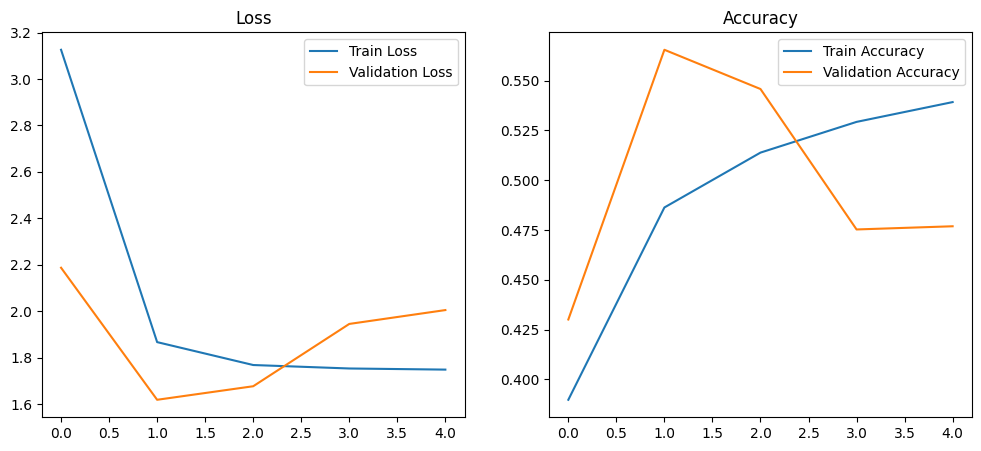

Saved files at: /home/digital101/MachineVisionProjects/ApplyChapter2Concepts


In [27]:

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.savefig("training_history1.png")  # Save as a single image

plt.show()
print("Saved files at:", os.getcwd())

